In [1]:
import os
import re
import json
import logging
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
from tqdm import tqdm
import spacy

In [2]:
# 设置工作目录
project_root = '/Users/jessie/Documents/Projects/Cusanus_Topic_Modeling'
os.chdir(project_root)
print("Current working directory: ", os.getcwd())

# 设置路径
base_dir = "/Users/jessie/Documents/Projects/Cusanus_Topic_Modeling"
input_dir = os.path.join(base_dir, "data/v_variant")  # XML文件所在目录
output_dir = os.path.join(base_dir, "data/preprocessed/spacy")  # 预处理后的文本
stats_dir = os.path.join(base_dir, "results/preprocessed")  # 统计信息

# 创建必要的目录
os.makedirs(output_dir, exist_ok=True)
os.makedirs(stats_dir, exist_ok=True)

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("logs/preprocessing.log"),
        logging.StreamHandler()
    ]
)

# 加载拉丁语模型
try:
    nlp = spacy.load('la_core_web_lg')
    logging.info("成功加载Spacy拉丁语模型")
except:
    logging.error("无法加载Spacy拉丁语模型，请确保已安装")
    raise

Current working directory:  /Users/jessie/Documents/Projects/Cusanus_Topic_Modeling


2024-11-24 15:20:36,736 - INFO - 成功加载Spacy拉丁语模型


In [4]:
# 加载停用词
with open('data/external/stopwords_latin.txt', 'r', encoding='utf-8') as f:
    LATIN_STOPS = set(f.read().splitlines())
logging.info(f"成功加载 {len(LATIN_STOPS)} 个自定义停用词")

2024-11-24 15:21:04,898 - INFO - 成功加载 4022 个自定义停用词


In [5]:
class LatinPreprocessor:
    def __init__(self):
        self.nlp = nlp
        
        # 统计数据
        self.word_freq = Counter()
        self.pos_stats = Counter()
        self.word_pos = {}
        self.total_paragraphs = 0
        self.total_words = 0
        
        # 加载停用词
        self.stopwords = LATIN_STOPS
        
        # 词性过滤配置
        self.VALID_POS = {'NOUN', 'ADJ', 'VERB', 'PROPN'}
        
    def process_word(self, word):
        """处理单个词"""
        try:
            # 清理词形
            word = word.lower()
            word = re.sub(r'\d+$', '', word)
            word = re.sub(r'[^a-zāēīōūȳĀĒĪŌŪȲ]', '', word)
            
            # 跳过德语词
            if re.search(r'[äöüß]', word):
                return None
            
            if not word or word in self.stopwords:
                return None
                
            # 词性标注和词形还原
            doc = self.nlp(word)
            if not doc:
                return None
            
            token = doc[0]
            pos = token.pos_
            
            # 更新统计信息
            self.pos_stats[pos] += 1
            
            if pos not in self.VALID_POS:
                return None
                
            lemma = token.lemma_
            if lemma:
                self.word_freq[lemma] += 1
                self.word_pos[lemma] = pos
                self.total_words += 1
                return lemma
                
        except Exception as e:
            logging.warning(f"处理词 '{word}' 时出错: {str(e)}")
            return None
            
        return None

    def process_file(self, file_path, output_path):
        """处理单个文件"""
        with open(file_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'lxml')
            paragraphs = []
            
            for fw_tag in soup.find_all('fw', {'type': 'n'}):
                section_content = []
                next_sibling = fw_tag.find_next_sibling()
                
                while next_sibling and next_sibling.name != 'fw':
                    if next_sibling.name == 'p':
                        words = []
                        for w in next_sibling.find_all('w'):
                            original_word = w.get('rend', w.get_text())
                            processed = self.process_word(original_word)
                            if processed:
                                words.append(processed)
                        
                        if words:
                            section_content.append(' '.join(words))
                    
                    next_sibling = next_sibling.find_next_sibling()
                
                if section_content:
                    paragraphs.append({'content': ' '.join(section_content)})
                    self.total_paragraphs += 1
            
            # 保存处理后的文本
            with open(output_path, 'w', encoding='utf-8') as f:
                for idx, paragraph in enumerate(paragraphs, 1):
                    if paragraph['content'].strip():
                        f.write(f"Paragraph {idx}:\n")
                        f.write(f"{paragraph['content']}\n\n")
            
            return paragraphs

    def save_statistics(self):
        """保存统计信息"""
        stats = {
            'total_words': self.total_words,
            'unique_words': len(self.word_freq),
            'total_paragraphs': self.total_paragraphs,
            'pos_distribution': dict(self.pos_stats)
        }
        
        # 保存基本统计信息
        stats_file = os.path.join(stats_dir, 'preprocessing_stats.json')
        with open(stats_file, 'w', encoding='utf-8') as f:
            json.dump(stats, f, ensure_ascii=False, indent=2)
        
        # 保存词频统计
        word_freq_df = pd.DataFrame([
            {'word': word, 'frequency': freq, 'pos': self.word_pos.get(word, 'UNKNOWN')}
            for word, freq in self.word_freq.most_common()
        ])
        word_freq_file = os.path.join(stats_dir, 'word_frequencies.csv')
        word_freq_df.to_csv(word_freq_file, index=False, encoding='utf-8')
        
        logging.info(f"统计信息已保存到 {stats_dir}")
        logging.info(f"总词数: {self.total_words}")
        logging.info(f"独特词数: {len(self.word_freq)}")
        logging.info(f"总段落数: {self.total_paragraphs}")
        logging.info("词性分布:")
        for pos, count in self.pos_stats.most_common():
            logging.info(f"  {pos}: {count}")

def main():
    processor = LatinPreprocessor()
    
    # 获取所有XML文件
    xml_files = [f for f in os.listdir(input_dir) if f.endswith('.xml')]
    logging.info(f"找到 {len(xml_files)} 个XML文件")
    
    # 处理所有文件
    for xml_file in tqdm(xml_files, desc="处理文件"):
        input_file = os.path.join(input_dir, xml_file)
        output_file = os.path.join(output_dir, xml_file.replace('.xml', '.txt'))
        
        try:
            paragraphs = processor.process_file(input_file, output_file)
            logging.info(f"处理文件 {xml_file}: 提取了 {len(paragraphs)} 个段落")
        except Exception as e:
            logging.error(f"处理文件 {xml_file} 时出错: {str(e)}")
            continue
    
    # 保存统计信息
    processor.save_statistics()

if __name__ == "__main__":
    main()

2024-11-24 15:21:07,172 - INFO - 找到 306 个XML文件
处理文件:   0%|          | 0/306 [00:00<?, ?it/s]/Users/jessie/miniforge3/envs/cusanus_env/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
2024-11-24 15:21:12,763 - INFO - 处理文件 v170_048.xml: 提取了 31 个段落
处理文件:  96%|█████████▌| 293/306 [29:48<00:15,  1.20s/it]2024-11-24 15:50:55,689 - INFO - 处理文件 v180_139.xml: 提取了 1 个段落
2024-11-24 15:51:01,705 - INFO - 处理文件 v190_267.xml: 提取了 27 个段落
处理文件: 100%|██████████| 306/306 [30:23<00:00,  5.96s/it]
2024-11-24 15:51:30,485 - INFO - 统计信息已保存到 /Users/jessie/Documents/Pr

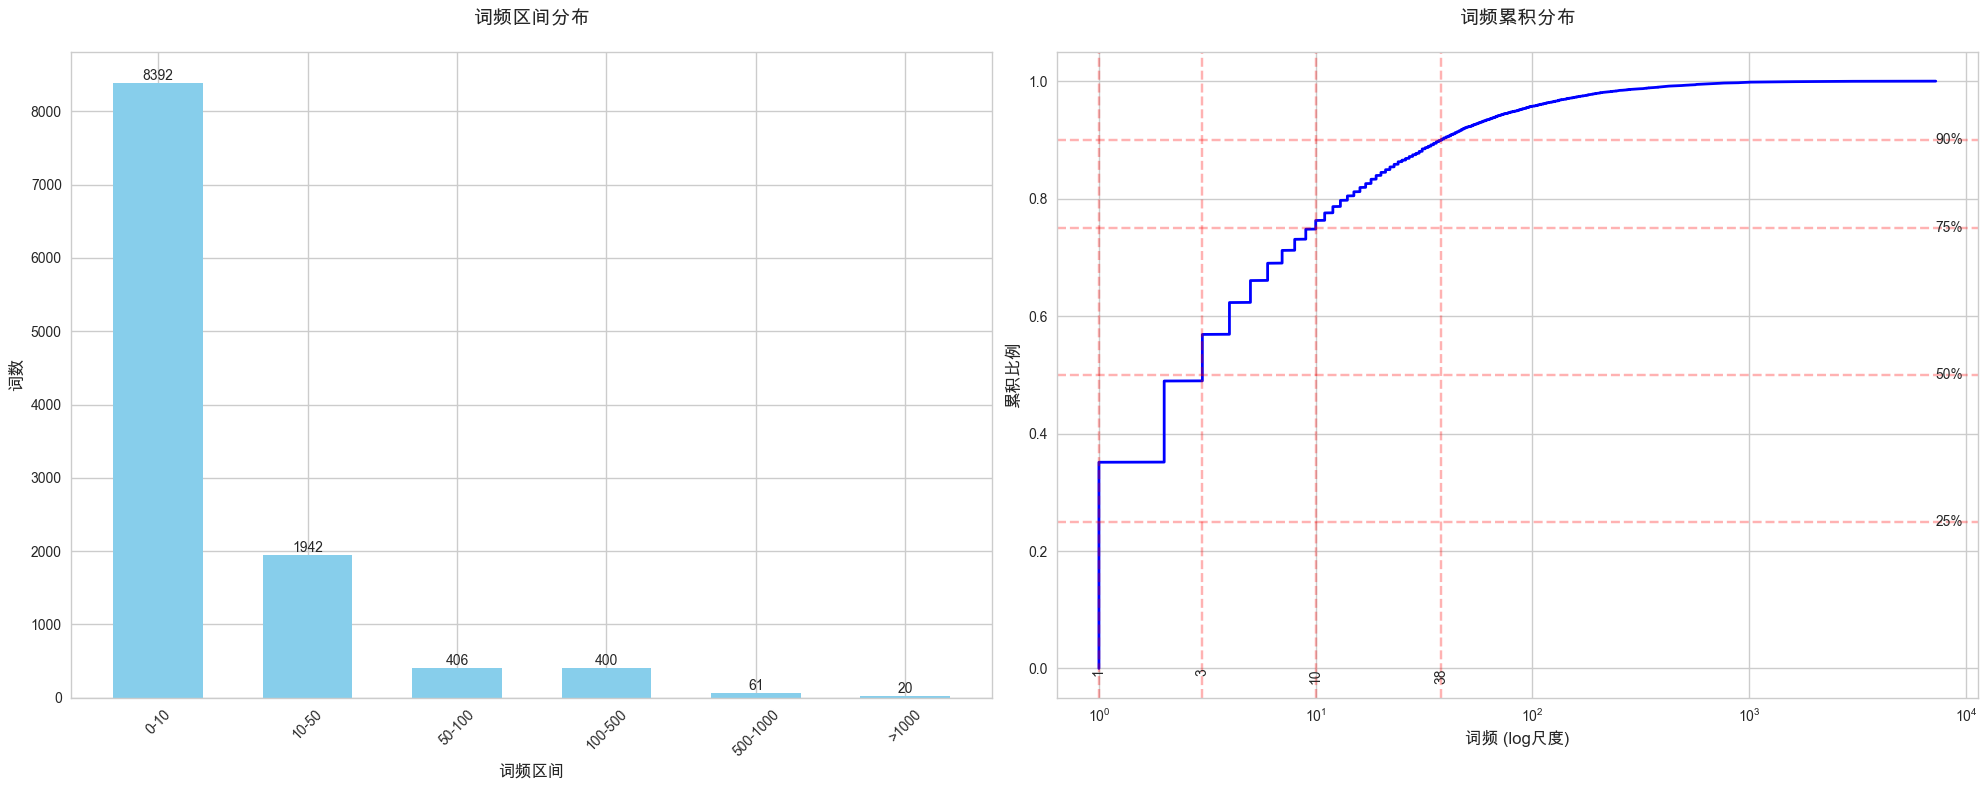


词频统计信息：
总词汇量：11,221 个词
最小词频：1
最大词频：7,250
平均词频：23.3
中位词频：3

词频分布：
0-10次: 8,392词 (74.8%)
10-50次: 1,942词 (17.3%)
50-100次: 406词 (3.6%)
100-500次: 400词 (3.6%)
500-1000次: 61词 (0.5%)
>1000次: 20词 (0.2%)

分位数分布：
10%分位数: 1
25%分位数: 1
50%分位数: 3
75%分位数: 10
90%分位数: 38
95%分位数: 86
99%分位数: 385


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 读取词频数据
df = pd.read_csv('results/preprocessed/spacy_word_frequencies.csv')

# 设置风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 左图：词频分布（使用区间分组）
freq_ranges = [(0, 10), (10, 50), (50, 100), (100, 500), (500, 1000), (1000, float('inf'))]
freq_counts = []
for start, end in freq_ranges:
    count = len(df[(df['frequency'] >= start) & (df['frequency'] < end)])
    freq_counts.append(count)

ax1.bar(range(len(freq_ranges)), freq_counts, 
        width=0.6,
        color='skyblue')
ax1.set_xticks(range(len(freq_ranges)))
ax1.set_xticklabels([f'{r[0]}-{r[1]}' if r[1] != float('inf') else f'>{r[0]}' 
                     for r in freq_ranges], rotation=45)
ax1.set_title('词频区间分布', fontsize=14, pad=20)
ax1.set_xlabel('词频区间', fontsize=12)
ax1.set_ylabel('词数', fontsize=12)

# 在柱子上添加具体数值
for i, count in enumerate(freq_counts):
    ax1.text(i, count, str(count), ha='center', va='bottom')

# 右图：累积分布函数（CDF）
frequencies = sorted(df['frequency'].values)
cumulative = np.arange(1, len(frequencies) + 1) / len(frequencies)

ax2.plot(frequencies, cumulative, 'b-', linewidth=2)
ax2.set_xscale('log')
ax2.set_title('词频累积分布', fontsize=14, pad=20)
ax2.set_xlabel('词频 (log尺度)', fontsize=12)
ax2.set_ylabel('累积比例', fontsize=12)

# 添加关键分位数标记
quantiles = [0.25, 0.5, 0.75, 0.9]
for q in quantiles:
    q_value = np.quantile(frequencies, q)
    ax2.axhline(y=q, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=q_value, color='r', linestyle='--', alpha=0.3)
    ax2.text(frequencies[-1], q, f'{int(q*100)}%', va='center')
    ax2.text(q_value, 0, f'{int(q_value)}', ha='center', va='top', rotation=90)

plt.tight_layout()
plt.show()

# 打印详细的统计信息
print("\n词频统计信息：")
print(f"总词汇量：{len(df):,} 个词")
print(f"最小词频：{df['frequency'].min():,}")
print(f"最大词频：{df['frequency'].max():,}")
print(f"平均词频：{df['frequency'].mean():.1f}")
print(f"中位词频：{df['frequency'].median():.0f}")

print("\n词频分布：")
for start, end in freq_ranges:
    count = len(df[(df['frequency'] >= start) & (df['frequency'] < end)])
    total = len(df)
    if end == float('inf'):
        print(f">{start}次: {count:,}词 ({count/total*100:.1f}%)")
    else:
        print(f"{start}-{end}次: {count:,}词 ({count/total*100:.1f}%)")

print("\n分位数分布：")
for q in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"{int(q*100)}%分位数: {df['frequency'].quantile(q):.0f}")

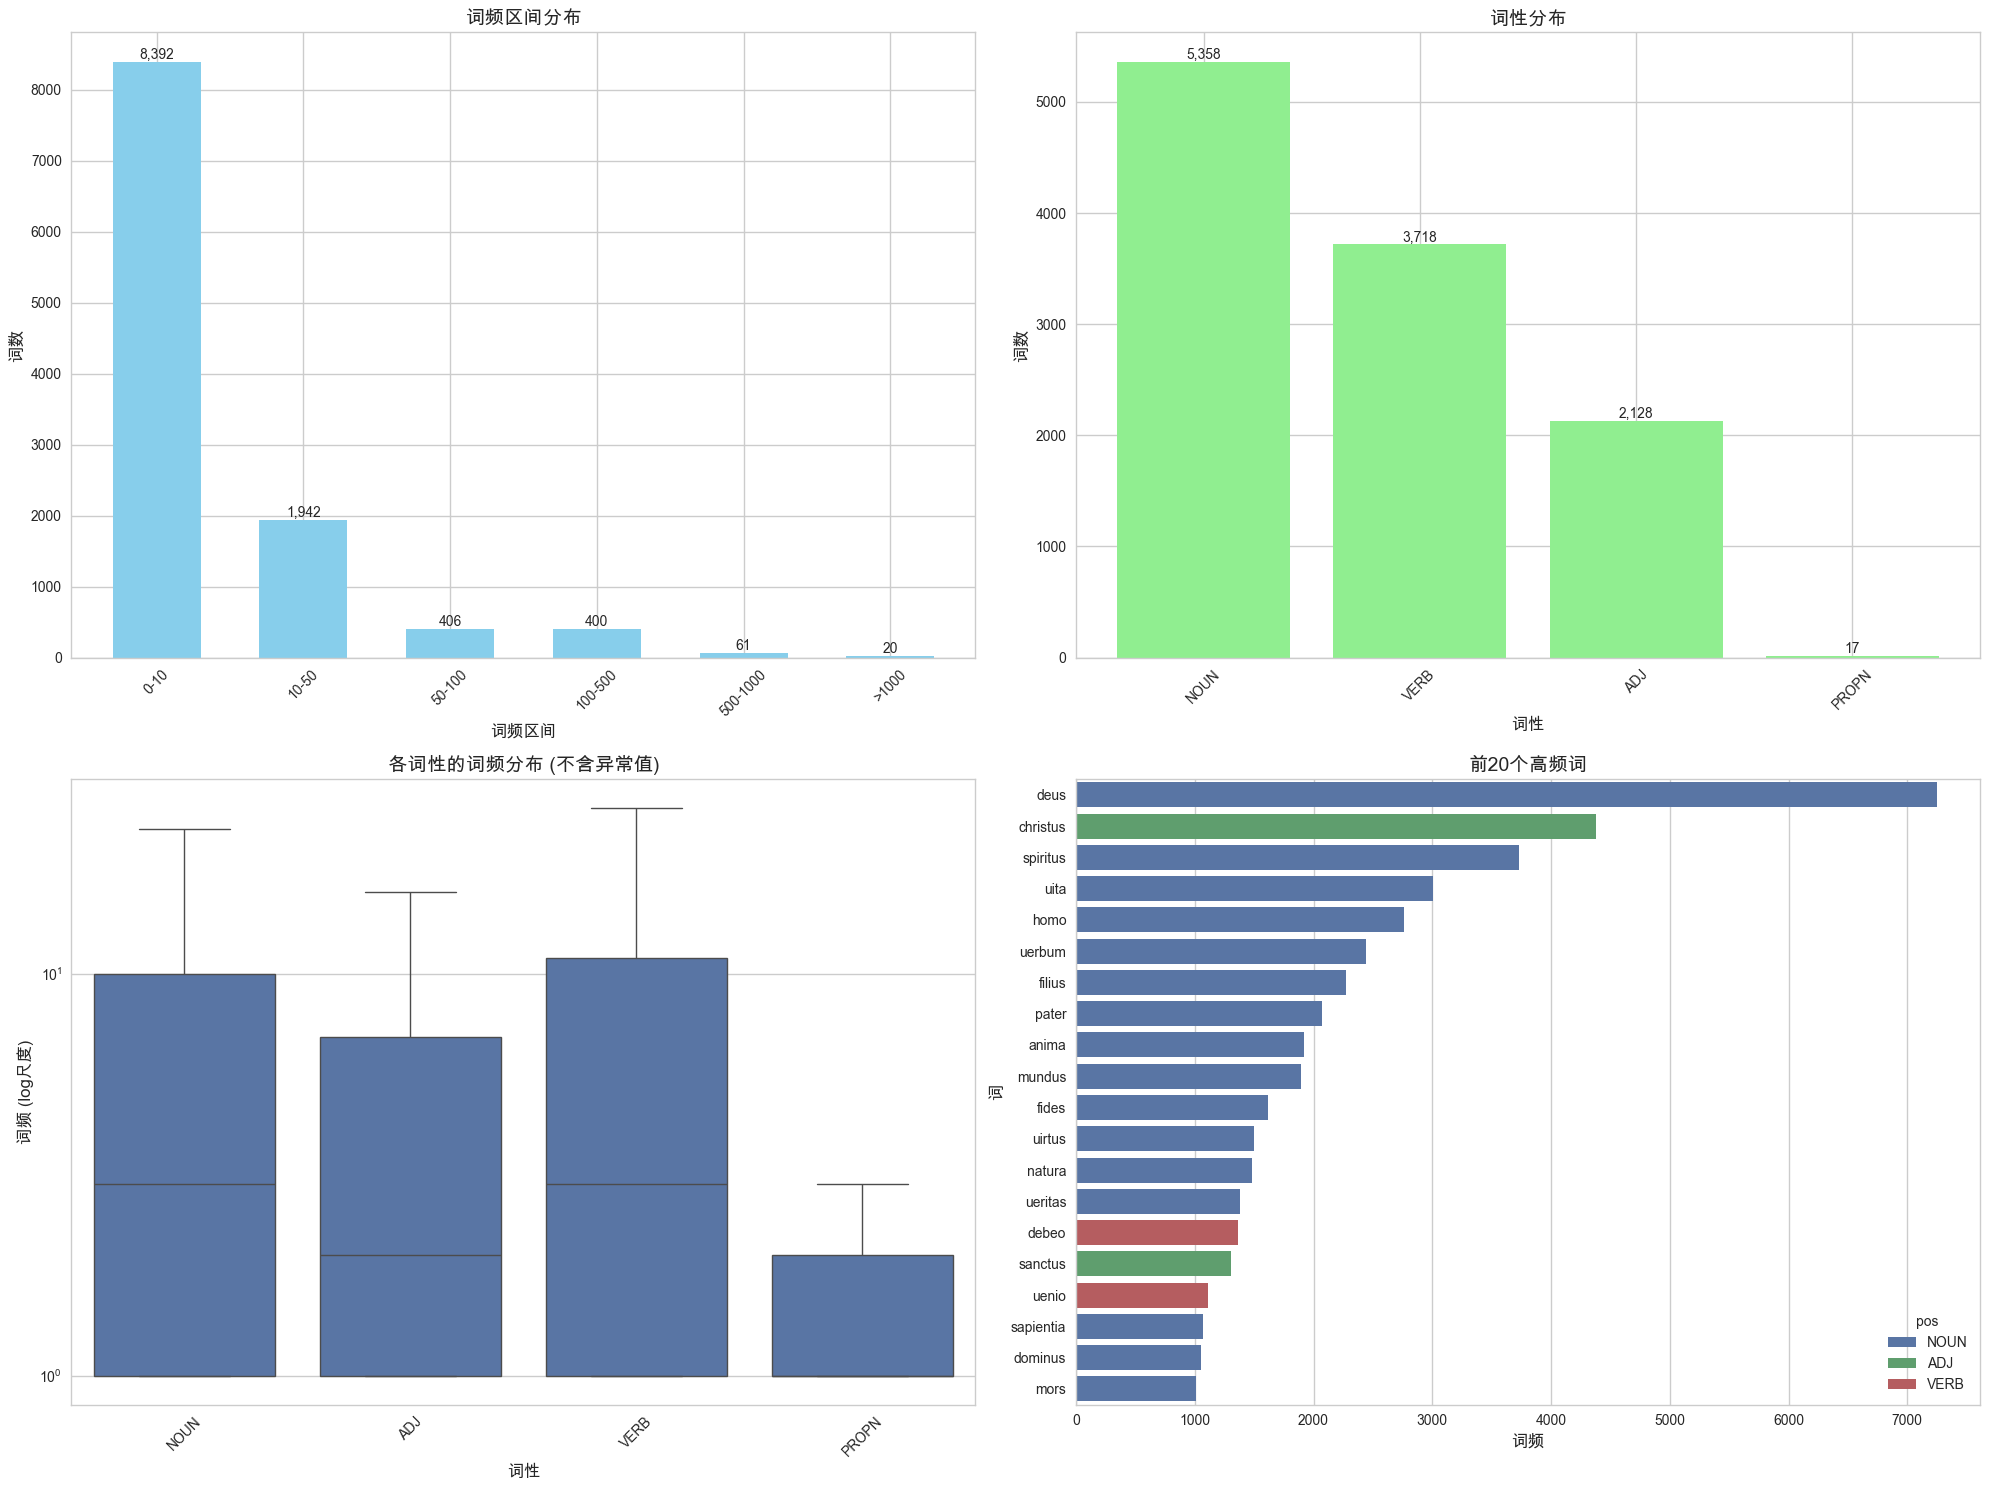


各词性的词频统计：
      frequency                        
          count min   max   mean median
pos                                    
ADJ        2128   1  4381  18.49    2.0
NOUN       5358   1  7250  27.20    3.0
PROPN        17   1     4   1.65    1.0
VERB       3718   1  1362  20.60    3.0

各词性的高频词（前10个）：

NOUN:
deus: 7250
spiritus: 3726
uita: 3010
homo: 2760
uerbum: 2443
filius: 2274
pater: 2072
anima: 1918
mundus: 1898
fides: 1618

ADJ:
christus: 4381
sanctus: 1305
primus: 925
aeternus: 882
uerus: 795
magnus: 725
intellectualis: 643
sensibilis: 588
diuinus: 570
bonus: 568

VERB:
debeo: 1362
uenio: 1110
uolo: 992
credo: 981
uiuo: 813
scio: 749
recipio: 729
nosco: 727
ostendo: 699
audio: 645

PROPN:
keinus: 4
leg: 3
seth: 3
ydermas: 3
bel: 2
loth: 2
ioth: 1
kallus: 1
sabahoth: 1
abzukche: 1


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 读取词频数据
df = pd.read_csv('results/preprocessed/spacy_word_frequencies.csv')

# 设置风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 创建多子图
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2)

# 1. 词频区间分布（左上）
ax1 = fig.add_subplot(gs[0, 0])
freq_ranges = [(0, 10), (10, 50), (50, 100), (100, 500), (500, 1000), (1000, float('inf'))]
freq_counts = []
for start, end in freq_ranges:
    count = len(df[(df['frequency'] >= start) & (df['frequency'] < end)])
    freq_counts.append(count)

ax1.bar(range(len(freq_ranges)), freq_counts, width=0.6, color='skyblue')
ax1.set_xticks(range(len(freq_ranges)))
ax1.set_xticklabels([f'{r[0]}-{r[1]}' if r[1] != float('inf') else f'>{r[0]}' 
                     for r in freq_ranges], rotation=45)
ax1.set_title('词频区间分布', fontsize=14)
ax1.set_xlabel('词频区间', fontsize=12)
ax1.set_ylabel('词数', fontsize=12)

# 添加数值标签
for i, count in enumerate(freq_counts):
    ax1.text(i, count, f'{count:,}', ha='center', va='bottom')

# 2. 词性分布（右上）
ax2 = fig.add_subplot(gs[0, 1])
pos_counts = df['pos'].value_counts()
ax2.bar(range(len(pos_counts)), pos_counts.values, color='lightgreen')
ax2.set_xticks(range(len(pos_counts)))
ax2.set_xticklabels(pos_counts.index, rotation=45)
ax2.set_title('词性分布', fontsize=14)
ax2.set_xlabel('词性', fontsize=12)
ax2.set_ylabel('词数', fontsize=12)

# 添加数值标签
for i, count in enumerate(pos_counts.values):
    ax2.text(i, count, f'{count:,}', ha='center', va='bottom')

# 3. 各词性的词频箱型图（左下）
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df, x='pos', y='frequency', showfliers=False, ax=ax3)
ax3.set_yscale('log')
ax3.set_title('各词性的词频分布 (不含异常值)', fontsize=14)
ax3.set_xlabel('词性', fontsize=12)
ax3.set_ylabel('词频 (log尺度)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)

# 4. 高频词分析（右下）
ax4 = fig.add_subplot(gs[1, 1])
top_n = 20
top_words = df.nlargest(top_n, 'frequency')
sns.barplot(data=top_words, x='frequency', y='word', hue='pos', ax=ax4)
ax4.set_title(f'前{top_n}个高频词', fontsize=14)
ax4.set_xlabel('词频', fontsize=12)
ax4.set_ylabel('词', fontsize=12)

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("\n各词性的词频统计：")
pos_stats = df.groupby('pos').agg({
    'frequency': ['count', 'min', 'max', 'mean', 'median']
}).round(2)
print(pos_stats)

print("\n各词性的高频词（前10个）：")
for pos in df['pos'].unique():
    top_words = df[df['pos'] == pos].nlargest(10, 'frequency')
    print(f"\n{pos}:")
    for _, row in top_words.iterrows():
        print(f"{row['word']}: {row['frequency']}")

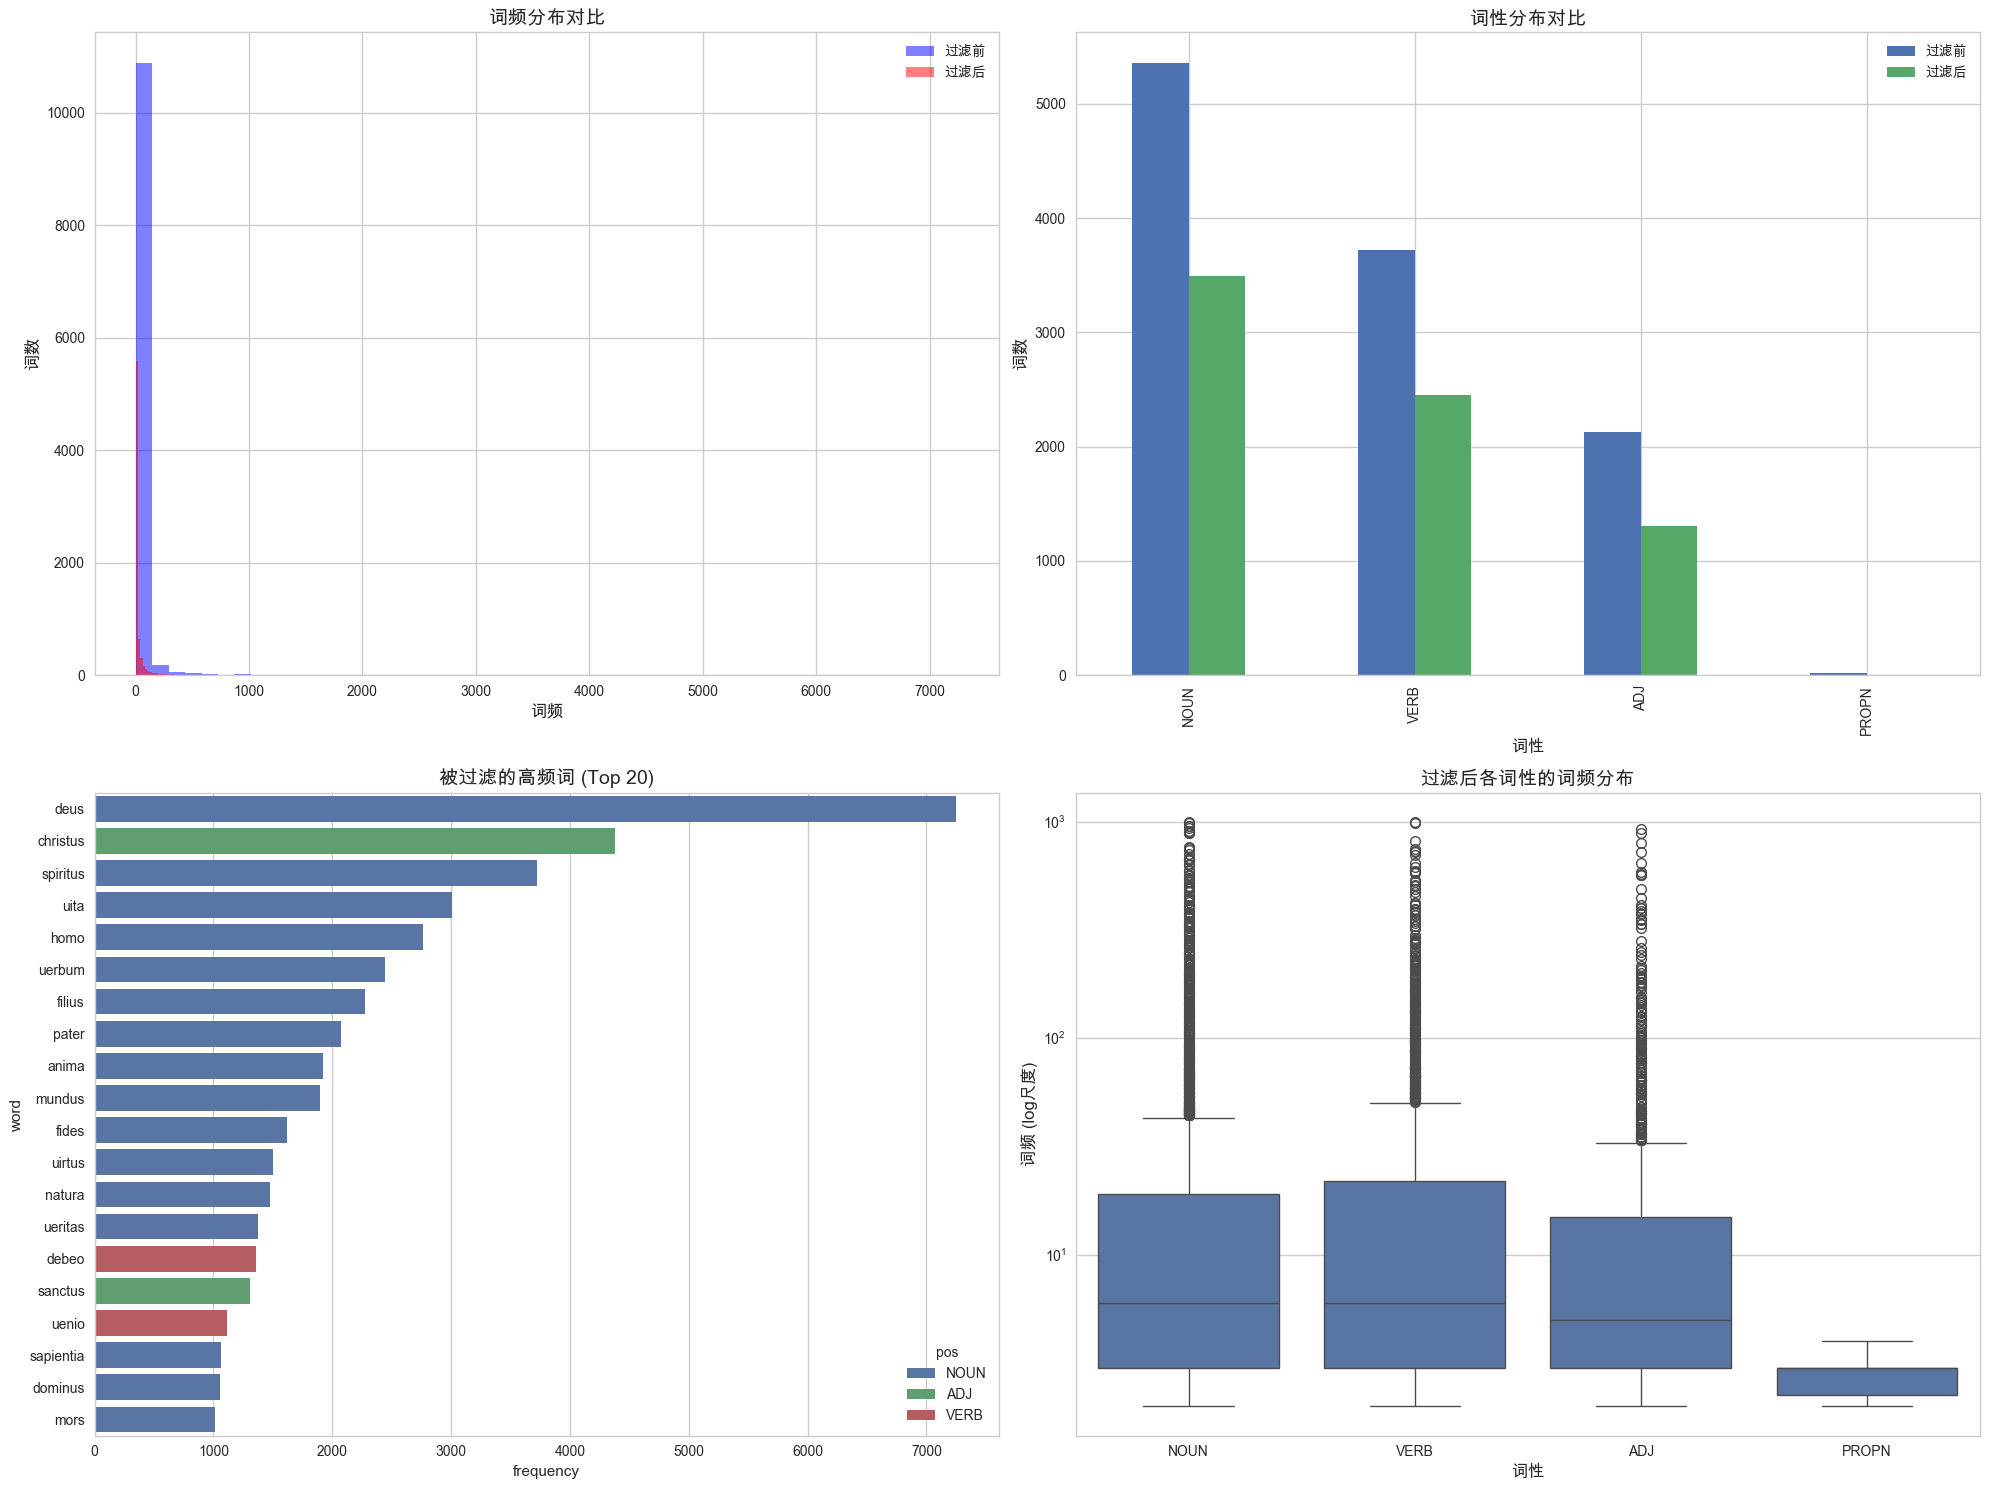


=== 过滤前后对比 ===
过滤前总词数：11,221
过滤后总词数：7,261
过滤掉的词数：3,960

=== 被过滤掉的高频词 (Top 20) ===
deus (NOUN): 7,250
christus (ADJ): 4,381
spiritus (NOUN): 3,726
uita (NOUN): 3,010
homo (NOUN): 2,760
uerbum (NOUN): 2,443
filius (NOUN): 2,274
pater (NOUN): 2,072
anima (NOUN): 1,918
mundus (NOUN): 1,898
fides (NOUN): 1,618
uirtus (NOUN): 1,502
natura (NOUN): 1,480
ueritas (NOUN): 1,378
debeo (VERB): 1,362
sanctus (ADJ): 1,305
uenio (VERB): 1,110
sapientia (NOUN): 1,067
dominus (NOUN): 1,055
mors (NOUN): 1,011

=== 各词性统计 ===
      frequency                       
          count min  max   mean median
pos                                   
ADJ        1308   2  925  25.10    5.0
NOUN       3493   2  997  30.76    6.0
PROPN         6   2    4   2.83    3.0
VERB       2454   2  992  29.69    6.0


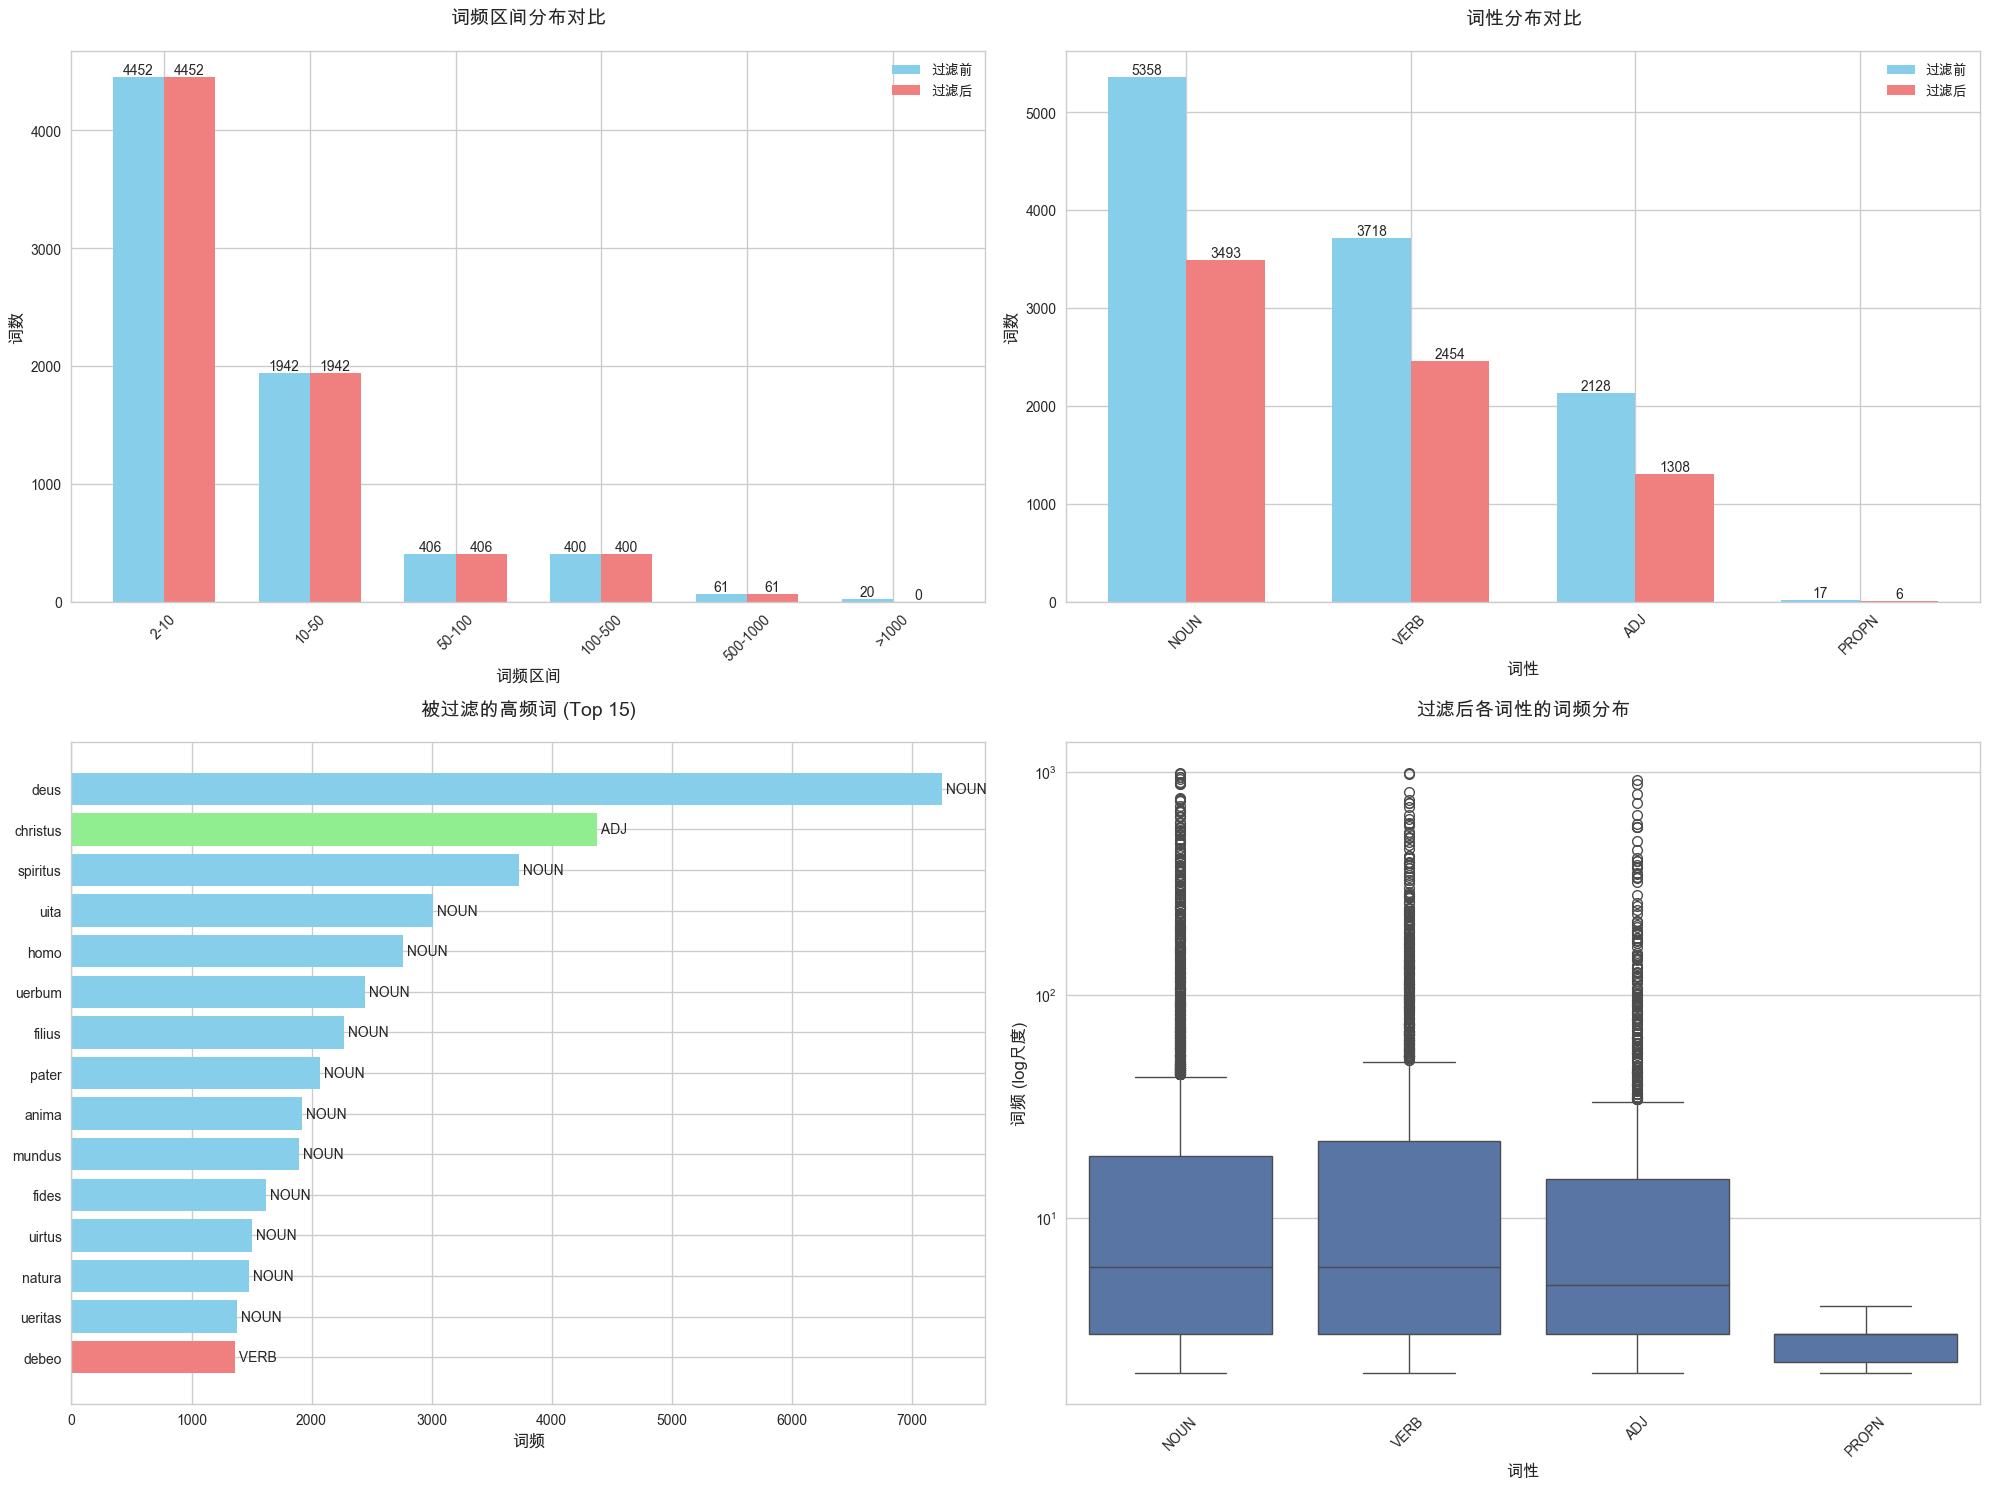


=== 过滤前后统计 ===
过滤前总词数：11,221
过滤后总词数：7,261
过滤掉的词数：3,960

=== 各词性过滤前后对比 ===
        过滤前   过滤后   减少比例
pos                     
NOUN   5358  3493  34.81
VERB   3718  2454  34.00
ADJ    2128  1308  38.53
PROPN    17     6  64.71

=== 高频词统计 ===
词频超过1000的词：
deus (NOUN): 7,250
christus (ADJ): 4,381
spiritus (NOUN): 3,726
uita (NOUN): 3,010
homo (NOUN): 2,760
uerbum (NOUN): 2,443
filius (NOUN): 2,274
pater (NOUN): 2,072
anima (NOUN): 1,918
mundus (NOUN): 1,898
fides (NOUN): 1,618
uirtus (NOUN): 1,502
natura (NOUN): 1,480
ueritas (NOUN): 1,378
debeo (VERB): 1,362
sanctus (ADJ): 1,305
uenio (VERB): 1,110
sapientia (NOUN): 1,067
dominus (NOUN): 1,055
mors (NOUN): 1,011

=== 词性分布统计 ===

NOUN:
count    3493.00
mean       30.76
std        88.77
min         2.00
25%         3.00
50%         6.00
75%        19.00
max       997.00
Name: frequency, dtype: float64

VERB:
count    2454.00
mean       29.69
std        74.58
min         2.00
25%         3.00
50%         6.00
75%        22.00
max       992.00

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 设置中文字体和样式
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS
plt.rcParams['axes.unicode_minus'] = False

def analyze_filtered_vocabulary(df, min_freq=2, max_freq=1000, output_dir='results/preprocessed'):
    """
    分析词汇过滤前后的统计特征
    
    参数:
    df: DataFrame, 包含词频数据
    min_freq: int, 最小词频阈值
    max_freq: int, 最大词频阈值
    output_dir: str, 输出目录
    """
    
    # 创建过滤后的数据框
    df_filtered = df[(df['frequency'] >= min_freq) & (df['frequency'] <= max_freq)].copy()
    
    # 创建图形
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])
    
    # 1. 词频区间分布（左上）
    ax1 = fig.add_subplot(gs[0, 0])
    freq_ranges = [(2, 10), (10, 50), (50, 100), (100, 500), (500, 1000), (1000, float('inf'))]
    freq_counts_before = []
    freq_counts_after = []
    
    for start, end in freq_ranges:
        count_before = len(df[(df['frequency'] >= start) & (df['frequency'] < end)])
        count_after = len(df_filtered[(df_filtered['frequency'] >= start) & 
                                    (df_filtered['frequency'] < end)])
        freq_counts_before.append(count_before)
        freq_counts_after.append(count_after)
    
    x = np.arange(len(freq_ranges))
    width = 0.35
    
    ax1.bar(x - width/2, freq_counts_before, width, label='过滤前', color='skyblue')
    ax1.bar(x + width/2, freq_counts_after, width, label='过滤后', color='lightcoral')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{r[0]}-{r[1]}' if r[1] != float('inf') else f'>{r[0]}' 
                         for r in freq_ranges], rotation=45)
    ax1.set_title('词频区间分布对比', fontsize=14, pad=20)
    ax1.set_xlabel('词频区间', fontsize=12)
    ax1.set_ylabel('词数', fontsize=12)
    ax1.legend()
    
    # 添加数值标签
    for i, v in enumerate(freq_counts_before):
        ax1.text(i - width/2, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(freq_counts_after):
        ax1.text(i + width/2, v, str(v), ha='center', va='bottom')
    
    # 2. 词性分布对比（右上）
    ax2 = fig.add_subplot(gs[0, 1])
    pos_before = df['pos'].value_counts()
    pos_after = df_filtered['pos'].value_counts()
    
    x = np.arange(len(pos_before))
    ax2.bar(x - width/2, pos_before.values, width, label='过滤前', color='skyblue')
    ax2.bar(x + width/2, pos_after.values, width, label='过滤后', color='lightcoral')
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(pos_before.index, rotation=45)
    ax2.set_title('词性分布对比', fontsize=14, pad=20)
    ax2.set_xlabel('词性', fontsize=12)
    ax2.set_ylabel('词数', fontsize=12)
    ax2.legend()
    
    # 添加数值标签
    for i, v in enumerate(pos_before.values):
        ax2.text(i - width/2, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(pos_after.values):
        ax2.text(i + width/2, v, str(v), ha='center', va='bottom')
    
    # 3. 被过滤的高频词（左下）
    ax3 = fig.add_subplot(gs[1, 0])
    high_freq_words = df[df['frequency'] > max_freq].sort_values('frequency', ascending=True).tail(15)
    
    colors = {'NOUN': 'skyblue', 'VERB': 'lightcoral', 'ADJ': 'lightgreen', 'PROPN': 'orange'}
    bars = ax3.barh(range(len(high_freq_words)), high_freq_words['frequency'],
                    color=[colors.get(pos, 'gray') for pos in high_freq_words['pos']])
    
    ax3.set_yticks(range(len(high_freq_words)))
    ax3.set_yticklabels(high_freq_words['word'])
    ax3.set_title('被过滤的高频词 (Top 15)', fontsize=14, pad=20)
    ax3.set_xlabel('词频', fontsize=12)
    
    # 添加词性标签
    for i, bar in enumerate(bars):
        ax3.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f" {high_freq_words.iloc[i]['pos']}", 
                va='center')
    
    # 4. 过滤后词频分布（右下）
    ax4 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=df_filtered, x='pos', y='frequency', ax=ax4)
    ax4.set_yscale('log')
    ax4.set_title('过滤后各词性的词频分布', fontsize=14, pad=20)
    ax4.set_xlabel('词性', fontsize=12)
    ax4.set_ylabel('词频 (log尺度)', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("\n=== 过滤前后统计 ===")
    print(f"过滤前总词数：{len(df):,}")
    print(f"过滤后总词数：{len(df_filtered):,}")
    print(f"过滤掉的词数：{len(df) - len(df_filtered):,}")
    
    print("\n=== 各词性过滤前后对比 ===")
    pos_compare = pd.DataFrame({
        '过滤前': pos_before,
        '过滤后': pos_after,
        '减少比例': (pos_before - pos_after) / pos_before * 100
    }).round(2)
    print(pos_compare)
    
    # 保存详细统计信息
    stats = {
        '过滤前': {
            '总词数': len(df),
            '总词频': df['frequency'].sum(),
            '各词性数量': df['pos'].value_counts().to_dict(),
            '词频统计': {
                '最小值': df['frequency'].min(),
                '最大值': df['frequency'].max(),
                '平均值': df['frequency'].mean(),
                '中位数': df['frequency'].median(),
                '标准差': df['frequency'].std()
            }
        },
        '过滤后': {
            '总词数': len(df_filtered),
            '总词频': df_filtered['frequency'].sum(),
            '各词性数量': df_filtered['pos'].value_counts().to_dict(),
            '词频统计': {
                '最小值': df_filtered['frequency'].min(),
                '最大值': df_filtered['frequency'].max(),
                '平均值': df_filtered['frequency'].mean(),
                '中位数': df_filtered['frequency'].median(),
                '标准差': df_filtered['frequency'].std()
            }
        }
    }
    
    # 保存统计结果
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存过滤后的词典
    filtered_df.to_csv(os.path.join(output_dir, 'spacy_filtered_vocabulary.csv'), index=False)
    
    # 保存统计信息
    pd.DataFrame(pos_compare).to_csv(os.path.join(output_dir, 'spacy_pos_statistics.csv'))
    
    # 保存高频词列表
    high_freq_words.to_csv(os.path.join(output_dir, 'spacy_high_frequency_words.csv'), index=False)
    
    return df_filtered, stats

# 读取原始词频数据
df = pd.read_csv('results/preprocessed/spacy_word_frequencies.csv')

# 运行分析
filtered_df, stats = analyze_filtered_vocabulary(df, min_freq=2, max_freq=1000)

# 打印一些额外的统计信息
print("\n=== 高频词统计 ===")
print("词频超过1000的词：")
for _, row in df[df['frequency'] > 1000].sort_values('frequency', ascending=False).iterrows():
    print(f"{row['word']} ({row['pos']}): {row['frequency']:,}")

print("\n=== 词性分布统计 ===")
for pos in filtered_df['pos'].unique():
    pos_stats = filtered_df[filtered_df['pos'] == pos]['frequency'].describe()
    print(f"\n{pos}:")
    print(pos_stats.round(2))